# Packages Installation

In [ ]:
!pip install scikeras[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.optimize import check_grad

# ConvNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from keras.utils import plot_model, to_categorical

# MLP
from typing import List
from tqdm import tqdm

# Hyperparameter tuning with GridSearch (task 3-6)
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

# Task 1: Acquire the data

## Notes on Processing
*   Followed this [tensorflow guide](https://www.tensorflow.org/tutorials/keras/classification) to import the images into numpy arrays.
*   60K training examples, with each image being 28x28 pixels
*  10K testing images

Notes on normalization from [this website](https://cs231n.github.io/neural-networks-2/#datapre): 

*   "It only makes sense to apply this preprocessing if you have a reason to believe that different input features have different scales (or units), but they should be of approximately equal importance to the learning algorithm. In case of images, the relative scales of pixels are already approximately equal (and in range from 0 to 255), so it is not strictly necessary to perform this additional preprocessing step."

*   "it is very important to zero-center the data, and it is common to see normalization of every pixel as well."





## Load data

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train_pre_ohe), (X_test, y_test_pre_ohe) = fashion_mnist.load_data()

In [ ]:
categories = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Explore data distribution

60K training, 10k testing. Evenly split across 10 classes (so, 6k per class in training, 1k per class in testing).

In [ ]:
print(X_train.shape)
print(y_train_pre_ohe.shape)
print(X_test.shape)
print(y_test_pre_ohe.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [ ]:
# The results of the below don't tell us much it seems
# df_X = pd.DataFrame(X_train)
# df_y = pd.DataFrame(y_train)
# print(df_X.describe())
# print(df_y.describe())

print(f"Count per class (train): {np.bincount(y_train_pre_ohe)}")
print(f"Count per class (test): {np.bincount(y_test_pre_ohe)}")

Count per class (train): [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]
Count per class (test): [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


## One hot encoding of y

y_train_pre_ohe & y_test_pre_ohe still kept so we can get labels by indexing in categories (see for example the Explore data section).

In [ ]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train_pre_ohe.reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(y_test_pre_ohe.reshape(-1, 1)).toarray()

## Normalizing X & X_not_normalized

Per the [tensorflow guide](https://www.tensorflow.org/tutorials/keras/classification), since all values are between 0 and 255, it is sufficient to divide them by 255 as a way of performing the normalization. This will make all values between 0 and 1. 

In [ ]:
X_train_not_normalized = X_train / 1
X_test_not_normalized = X_test / 1
X_train = X_train / 255
X_test = X_test / 255

## Visualize data

Note: this is done before we vectorize so that we can view the images to see what the dataset looks like.

Training set


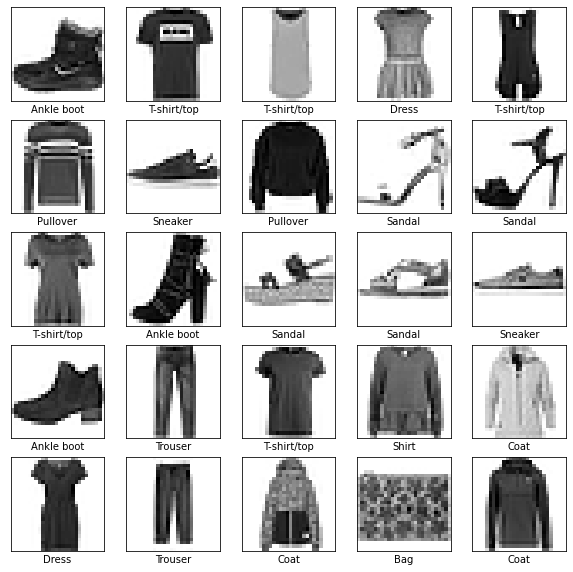

Testing set


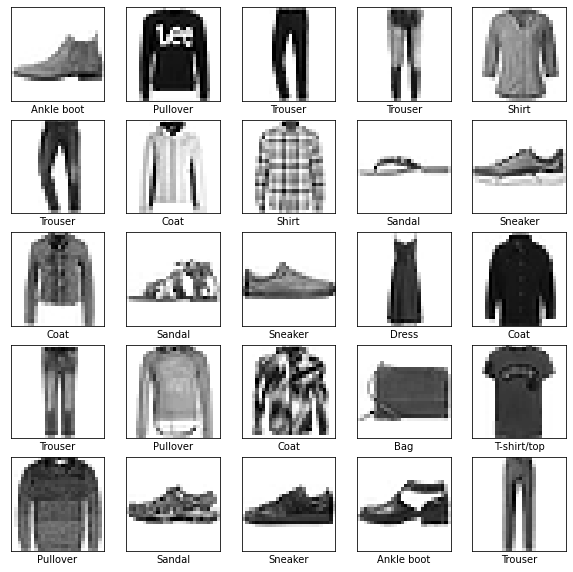

In [ ]:
print("Training set")
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(categories[y_train_pre_ohe[i]])
plt.show()

print("Testing set")
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)
    plt.xlabel(categories[y_test_pre_ohe[i]])
plt.show()

## Sets for ConvNet

It works with pre-OHE labels and un-vectorized data. Also, it makes use of validation sets. 

In [ ]:
X_train_pre_vect = X_train
X_test_pre_vect = X_test
X_train_w_val, X_val, y_train_w_val, y_val = train_test_split(
    X_train_pre_vect, y_train_pre_ohe, test_size = 0.2, random_state=1, shuffle=True)

## Vectorize Images in X

We do this by flatting the images. Each image (so, each element of X) is a 28x28 2D array. So, we convert each image into a 28x28=784 long array so that each image is represented by just one flattened array.

In [ ]:
# Vectorize normalized X
flat = []
for image in X_train:
  flat.append(image.flatten())
flat = np.array(flat)
X_train = flat

flat = []
for image in X_test:
  flat.append(image.flatten())
flat = np.array(flat)
X_test = flat

# Vectorize not normalized X
flat = []
for image in X_train_not_normalized:
  flat.append(image.flatten())
flat = np.array(flat)
X_train_not_normalized = flat

flat = []
for image in X_test_not_normalized:
  flat.append(image.flatten())
flat = np.array(flat)
X_test_not_normalized = flat

del flat # no more need for this, save space

## Mini sets for plots

In [ ]:
indices = np.random.choice(X_test.shape[0], 500, replace=False)
X_test_mini = X_test[indices]
y_test_mini = y_test[indices]
X_train_mini = X_train[indices]
y_train_mini = y_train[indices]

## Variable list

*   **X_train** and **y_train** for training
*   **X_test** and **y_test** for testing
*   Mini sets used just for accuracy plots
*   **X_train_not_normalized** for pre-normalized X_train; same for **X_test_not_normalized**
*   **y_train_pre_ohe** & **y_test_pre_ohe** have y values pre-one-hot-encoding; useful for getting category index when passed to **categories** list
*   Stuff for ConvNet: **Y_train_w_val** and **y_train_w_val** for 80% size training set if validation with **X_val** and **y_val** is used. Note that these are pre-OHE and un-vectorized X.
*   **categories** contains the list of category names

# Task 2: MLP Implementation

Please note that the code in this section is heavily inspired from the class tutorial code.

## Layers

### Base Layer Class

In [ ]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
        
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError

### Softmax Output Layer

In [ ]:
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        z = x.max()
        exps = np.exp(x - z)
        probs = exps / np.sum(exps, axis=-1)[:, None]
        self.cur_probs = probs
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

### LinearLayer

In [ ]:
class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size, regularization=False, lmbd=0, perturb=False, rho=0):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = 0.2 * np.random.randn(output_size, input_size)
        self.b = np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]
        self.regularization = regularization
        self.lmbd = lmbd
        self.epsilon = 1e-8
        self.small_perturb = perturb
        self.rho = rho

        # Small perturbation is roughly estimated by (L(w + eps*norm(rho)) - L(w))/eps
    
    def small_perturbation(self, gradient):
        first = np.sum(gradient.dot((self.w + (self.epsilon*self.rho))))
        second = np.sum(gradient.dot(self.w))
        print((first - second)/self.epsilon)

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        grad = 0
        if self.regularization:
            grad = gradient.dot(self.w) + gradient.dot(self.lmbd * self.w)
        else:
            grad = gradient.dot(self.w)

        if self.small_perturb:
            self.small_perturbation(gradient)
        
        return grad

### ReLU Layer

In [ ]:
class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):        
        # Where gradients are calculated, regularization is done
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

### Leaky ReLU Layer

Leaky ReLU is f(x)=xI[x≥0]+αxI[x<0] from ed. 
So, gradient is: 
- For x >= 0: 1
- For x < 0: α

We set α to 0.01 as that is the [PyTorch default](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html)

In [ ]:
class LeakyReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x >= 0, 1.0, 0.01)
        return np.maximum(0, x) + 0.01 * np.minimum(x, 0)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

### Tanh Layer

In [ ]:
class TanhLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        z = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
        self.gradient = np.ones(x.shape) - (z*z)
        return z

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

## MLP

In [ ]:
from pickle import FALSE
class MLP:
    def __init__(self, activationFunction, numHiddenLayers, numUnitsHiddenLayers, inputSize, outputSize, epoch_number, mini_batch_size, regularization=False, lmbd=0, small_perturb=False):
      # Should:
      #   - initialize weight
      #   - initialize biases
      #   - initialize other important properities of the MLP
        self.regularization = regularization
        self.lmbd = lmbd
        self.activationFunction = activationFunction
        self.numHiddenLayers = numHiddenLayers
        self.numUnitsHiddenLayers = numUnitsHiddenLayers
        self.optimizer = GradientDescentOptimizer(self, 1e-2, regularization, lmbd)
        self.inputSize = inputSize    # Input to the MLP (X)
        self.outputSize = outputSize    # Output from the MLP (y)
        self.mini_batch_size = mini_batch_size      # Size of each mini-batch
        self.epoch_number = epoch_number    # Number of epochs
        self.layers = []    # list of NeuralNetLayers

        # Add first linearLayer
        rho = 0.01 * np.random.randn(self.numUnitsHiddenLayers, self.inputSize)
        norm = np.linalg.norm(rho)
        self.rho = rho/norm

        if self.numHiddenLayers > 0:
            self.layers.append(LinearLayer(self.inputSize, self.numUnitsHiddenLayers, self.regularization, self.lmbd, small_perturb, self.rho))
        else:
            self.numUnitsHiddenLayers = self.inputSize

        if (self.activationFunction.lower() == "relu"):
          for i in range(0, self.numHiddenLayers):
            self.layers.append(ReLULayer())
            if i != self.numHiddenLayers - 1:
                rho = 0.01 * np.random.randn(self.numUnitsHiddenLayers, self.numUnitsHiddenLayers)
                norm = np.linalg.norm(rho)
                self.rho = rho/norm
                self.layers.append(LinearLayer(self.numUnitsHiddenLayers, self.numUnitsHiddenLayers, self.regularization, self.lmbd, small_perturb, self.rho))
        
        elif (self.activationFunction.lower() == "leaky_relu"):
          for i in range(0, self.numHiddenLayers):
            self.layers.append(LeakyReLULayer())
            if i != self.numHiddenLayers - 1:
                rho = 0.01 * np.random.randn(self.numUnitsHiddenLayers, self.numUnitsHiddenLayers)
                norm = np.linalg.norm(rho)
                self.rho = rho/norm
                self.layers.append(LinearLayer(self.numUnitsHiddenLayers, self.numUnitsHiddenLayers, self.regularization, self.lmbd, small_perturb, self.rho))
        
        elif (self.activationFunction.lower() == "tanh"):
          for i in range(0, self.numHiddenLayers):
            self.layers.append(TanhLayer())
            if i != self.numHiddenLayers - 1:
                rho = 0.01 * np.random.randn(self.numUnitsHiddenLayers, self.numUnitsHiddenLayers)
                norm = np.linalg.norm(rho)
                self.rho = rho/norm
                self.layers.append(LinearLayer(self.numUnitsHiddenLayers, self.numUnitsHiddenLayers, self.regularization, self.lmbd, small_perturb, self.rho))

        elif (self.activationFunction.lower() == "linear"):
          for i in range(0, self.numHiddenLayers):
            self.layers.append(LinearLayer())

        else:
          raise Exception(self.activationFunction, "is an invalid activation function.")
        
        # Add linearLayer after hidden layers
        # Add linearLayer after each hidden layers.
        rho = 0.01 * np.random.randn(self.outputSize, self.numUnitsHiddenLayers)
        norm = np.linalg.norm(rho)
        self.rho = rho/norm
        self.layers.append(LinearLayer(self.numUnitsHiddenLayers, self.outputSize, self.regularization, self.lmbd, small_perturb, self.rho))

        # Add softmax
        self.layers.append(SoftmaxOutputLayer())

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)

    def fit(self, data_x, data_y):
      # losses = []
      train_accuracies = []
      test_accuracies = []
      data_size = len(data_x)

      # Permute the data, both x and y at the same time
      np.random.seed(12) # set the seed
      r = np.arange(len(data_x))
      np.random.shuffle(r)
      data_x = data_x[r]
      data_y = data_y[r]

      # Split in mini batches
      number_batches = np.rint(data_size/mini_batch_size)
      data_index = np.arange(data_size) # list of indices

      # different batches, each containing the indices to retrieve the data
      batches_index_list = np.split(data_index, number_batches)
      batches_counter = 0
      for _ in tqdm(range(self.epoch_number)):  # One iteration = one epoch
          batches_counter = 0     # reset for each epoch

          for _ in range(int(data_size / self.mini_batch_size)): # One iteration = one minibatch
          # for _ in range(self.mini_batch_size): # One iteration = one minibatch
              ### Mini-batch

              # Stores the indices of the data points which are included in this batch
              batch_indices = batches_index_list[batches_counter]
              batch = data_x[batch_indices]
              batch_labels = data_y[batch_indices]
              batches_counter += 1

              # Forward pass
              predictions = self.forward(batch)
              #print(predictions)
              
              # Check if predictions are yielding anomalous values.
              if np.any(predictions == 0):
                  print("There are some missing predictions")

              # Backward propagation to update gradients and weights
              self.backward(batch_labels)
              self.optimizer.step()
      
          # After 1 epoch -> Calculate cross entropy
          # loss = -(batch_labels * np.log(predictions)).sum(axis=-1).mean()
          # losses.append(loss)
          # After each epoch, calculate train and test accuracies
          y_train_pred = self.forward(X_train_mini)
          train_acc = self.evaluate_acc(y_train_mini, y_train_pred, verbose=False)
          train_accuracies.append(train_acc)
          y_test_pred = self.forward(X_test_mini)
          test_acc = self.evaluate_acc(y_test_mini, y_test_pred, verbose=False)
          test_accuracies.append(test_acc)

      # plt.plot(losses)
      # plt.xlabel("Epoch")
      # plt.ylabel("Cross entropy loss")
      plt.title("Accuracy")
      plt.ylabel("Accuracy")
      plt.xlabel("Epoch")
      plt.plot(train_accuracies, label='train')
      plt.plot(test_accuracies, label='test')
      plt.legend()
      plt.show()

    def predict(self, data_x):
      # Forward pass
      return self.forward(data_x)

    def evaluate_acc(self, y, y_pred, verbose=True):
      # Same as A2 I think
      accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
      accuracy = accuracy / y.shape[0]
      if verbose:
        print("Accuracy: ", accuracy)
      return accuracy

    def check_grad(self, data_x, data_y):
        losses = []
        data_size = len(data_x)

        # Permute the data, both x and y at the same time
        np.random.seed(12) # set the seed
        r = np.arange(len(data_x))
        np.random.shuffle(r)
        data_x = data_x[r]
        data_y = data_y[r]

        # Split in mini batches
        number_batches = np.rint(data_size/mini_batch_size)
        data_index = np.arange(data_size) # list of indices

        # different batches, each containing the indices to retrieve the data
        batches_index_list = np.split(data_index, number_batches)
        batches_counter = 0

        for _ in range(self.mini_batch_size): # One iteration = one minibatch
              ### Mini-batch

              # Stores the indices of the data points which are included in this batch
              batch_indices = batches_index_list[batches_counter]
              batch = data_x[batch_indices]
              batch_labels = data_y[batch_indices]
              batches_counter += 1

              # Forward pass
              predictions = self.forward(batch)
              
              # Check if predictions are yielding anomalous values.
              if np.any(predictions == 0):
                  print("There are some missing predictions")

              # Backward propagation to update gradients and weights
              self.backward(batch_labels)
              self.optimizer.step()


In [ ]:
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float, regularization=False, lmbd=0):
        super().__init__(net)
        self.lr = lr
        self.regularization = regularization
        self.lmbd = lmbd

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= (self.lr * g.mean(axis=0))

# Task 3: Exploration

## 1) Basic MLP's
**Notes:**


*   As expected, MLP with no hidden layers has very poor performance: acc 0.1
*   1 hidden layer: significant improvement to 0.8449 accuracy, 100 epochs.
*   2 layers w ReLU: 0.8548 with 100 epochs. Slight improvement over 1 layer. However, we see that the CE continuous to decrease even after 100 epochs, so we could run for longer (though it takes a long time)



### 1.0 Small Perturbation
We test the correctness of the weights. A numerical test is performed to check whether the weights change significantly throughout the fitting.

In [ ]:
mini_batch_size = 200
epoch_number = 50
numHiddenLayers = 1
HIDDEN_SIZE = 128

inputSize = X_train.shape[1]
outputSize = y_train.shape[1]
model = MLP("relu", numHiddenLayers , HIDDEN_SIZE, inputSize, outputSize, epoch_number, mini_batch_size, small_perturb=True)

model.check_grad(X_train, y_train)

23.136976778914686
-10.421308616059832
10.116434623341775
1.6055764717748389
20.516617382781988
-2.036404112004675
18.217015451682528
-1.126090865000151
10.110973391874722
-2.8347585612209514
11.541632005673819
-2.7979012884316035
15.948479514804603
-4.223772975819884
10.106032632961615
-5.100213229525252
9.42147480031963
-2.4464767989229586
3.645910950922371
-1.5598203617628315
10.38257693153355
2.759499295734713
9.282371937757716
-0.00021458390619955026
11.336498317859878
-5.928369262164779
0.7631861365098302
0.38283758385659894
14.441468465520302
0.2140986055110261
7.760623788044541
-0.9155954217021645
8.703990772573889
-5.606143815839459
7.26160909181317
0.44376236019161297
7.173172988927945
0.1926949266817246
14.219133781523396
2.8097332460674806
12.8543721888974
5.529071245291561
11.816675993259196
-3.6513853274300345
15.700441302612944
-3.189518338331254
4.988545843076508
0.853339088280336
4.215091986559116
0.20602755057552713
7.1984004534897394
-0.7472010565834353
13.1707528439

### 1.1 No hidden layers.
A MLP with only two linear functions and a softmax layer.

10
[<__main__.LinearLayer object at 0x7f81b5707b80>, <__main__.SoftmaxOutputLayer object at 0x7f81b5707f40>]


100%|██████████| 75/75 [05:20<00:00,  4.27s/it]


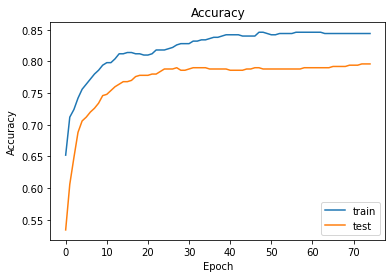

Accuracy:  0.8266


0.8266

In [ ]:
mini_batch_size = 200
epoch_number = 75
numHiddenLayers = 0
# Since we are directly feeding into softmax, make hidden size = 10.
HIDDEN_SIZE = 0

inputSize = X_train.shape[1]
outputSize = y_train.shape[1]
model = MLP("relu", numHiddenLayers , HIDDEN_SIZE, inputSize, outputSize, epoch_number, mini_batch_size)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
model.evaluate_acc(y_test, y_pred)

### 1.2 One Hidden Layer
A MLP with 1 hidden layer having 128 units and ReLU activations.

  0%|          | 0/75 [00:00<?, ?it/s]

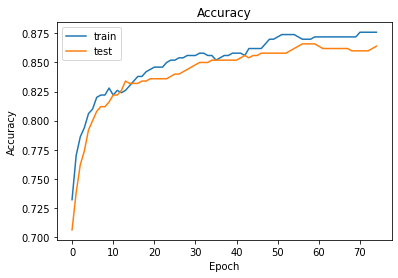

Accuracy:  0.8512


0.8512

In [ ]:
mini_batch_size = 200
epoch_number = 75
numHiddenLayers = 1
HIDDEN_SIZE = 128

inputSize = X_train.shape[1]
outputSize = y_train.shape[1]
model = MLP("relu", numHiddenLayers , HIDDEN_SIZE, inputSize, outputSize, epoch_number, mini_batch_size)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
model.evaluate_acc(y_test, y_pred)

In [ ]:
# Accuracy from 1-layer MLP w ReLU, 100 epochs
relu_acc = 0.8555

### 1.3 Two Hidden Layers
A MLP with 2 hidden layers each having 128 units with ReLU activations.

  2%|▏         | 1/50 [00:24<19:37, 24.03s/it]

Accuracy:  0.704


  4%|▍         | 2/50 [00:48<19:13, 24.03s/it]

Accuracy:  0.726


  6%|▌         | 3/50 [01:12<18:48, 24.01s/it]

Accuracy:  0.764


  8%|▊         | 4/50 [01:36<18:25, 24.03s/it]

Accuracy:  0.782


 10%|█         | 5/50 [02:00<18:14, 24.33s/it]

Accuracy:  0.788


 12%|█▏        | 6/50 [02:25<17:46, 24.24s/it]

Accuracy:  0.79


 14%|█▍        | 7/50 [02:49<17:19, 24.18s/it]

Accuracy:  0.802


 16%|█▌        | 8/50 [03:13<16:53, 24.12s/it]

Accuracy:  0.808


 18%|█▊        | 9/50 [03:37<16:27, 24.10s/it]

Accuracy:  0.818


 20%|██        | 10/50 [04:01<16:02, 24.05s/it]

Accuracy:  0.822


 22%|██▏       | 11/50 [04:25<15:47, 24.31s/it]

Accuracy:  0.824


 24%|██▍       | 12/50 [04:49<15:20, 24.22s/it]

Accuracy:  0.822


 26%|██▌       | 13/50 [05:13<14:52, 24.13s/it]

Accuracy:  0.824


 28%|██▊       | 14/50 [05:37<14:27, 24.09s/it]

Accuracy:  0.826


 30%|███       | 15/50 [06:01<14:02, 24.07s/it]

Accuracy:  0.83


 32%|███▏      | 16/50 [06:25<13:38, 24.06s/it]

Accuracy:  0.836


 34%|███▍      | 17/50 [06:50<13:14, 24.07s/it]

Accuracy:  0.836


 36%|███▌      | 18/50 [07:15<12:59, 24.34s/it]

Accuracy:  0.84


 38%|███▊      | 19/50 [07:39<12:32, 24.26s/it]

Accuracy:  0.838


 40%|████      | 20/50 [08:03<12:05, 24.19s/it]

Accuracy:  0.838


 42%|████▏     | 21/50 [08:27<11:40, 24.14s/it]

Accuracy:  0.838


 44%|████▍     | 22/50 [08:51<11:15, 24.14s/it]

Accuracy:  0.838


 46%|████▌     | 23/50 [09:15<10:51, 24.13s/it]

Accuracy:  0.838


 48%|████▊     | 24/50 [09:40<10:33, 24.38s/it]

Accuracy:  0.84


 50%|█████     | 25/50 [10:04<10:07, 24.29s/it]

Accuracy:  0.84


 52%|█████▏    | 26/50 [10:28<09:41, 24.22s/it]

Accuracy:  0.842


 54%|█████▍    | 27/50 [10:52<09:14, 24.12s/it]

Accuracy:  0.844


 56%|█████▌    | 28/50 [11:16<08:49, 24.09s/it]

Accuracy:  0.846


 58%|█████▊    | 29/50 [11:40<08:24, 24.03s/it]

Accuracy:  0.844


 60%|██████    | 30/50 [12:05<08:05, 24.26s/it]

Accuracy:  0.844


 62%|██████▏   | 31/50 [12:29<07:39, 24.18s/it]

Accuracy:  0.846


 64%|██████▍   | 32/50 [12:53<07:14, 24.14s/it]

Accuracy:  0.848


 66%|██████▌   | 33/50 [13:17<06:49, 24.09s/it]

Accuracy:  0.848


 68%|██████▊   | 34/50 [13:41<06:24, 24.05s/it]

Accuracy:  0.848


 70%|███████   | 35/50 [14:05<06:00, 24.04s/it]

Accuracy:  0.85


 72%|███████▏  | 36/50 [14:28<05:36, 24.00s/it]

Accuracy:  0.85


 74%|███████▍  | 37/50 [14:53<05:15, 24.28s/it]

Accuracy:  0.854


 76%|███████▌  | 38/50 [15:17<04:50, 24.17s/it]

Accuracy:  0.854


 78%|███████▊  | 39/50 [15:41<04:25, 24.11s/it]

Accuracy:  0.854


 80%|████████  | 40/50 [16:05<04:00, 24.08s/it]

Accuracy:  0.856


 82%|████████▏ | 41/50 [16:29<03:36, 24.07s/it]

Accuracy:  0.86


 84%|████████▍ | 42/50 [16:53<03:12, 24.04s/it]

Accuracy:  0.86


 86%|████████▌ | 43/50 [17:18<02:49, 24.25s/it]

Accuracy:  0.862


 88%|████████▊ | 44/50 [17:42<02:24, 24.10s/it]

Accuracy:  0.862


 90%|█████████ | 45/50 [18:06<02:00, 24.06s/it]

Accuracy:  0.864


 92%|█████████▏| 46/50 [18:30<01:36, 24.02s/it]

Accuracy:  0.864


 94%|█████████▍| 47/50 [18:54<01:11, 23.96s/it]

Accuracy:  0.864


 96%|█████████▌| 48/50 [19:17<00:47, 23.95s/it]

Accuracy:  0.864


 98%|█████████▊| 49/50 [19:41<00:23, 23.90s/it]

Accuracy:  0.864


100%|██████████| 50/50 [20:06<00:00, 24.13s/it]

Accuracy:  0.862


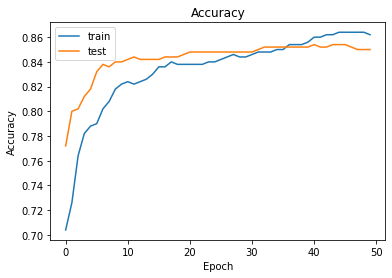

Accuracy:  0.8508


0.8508

In [ ]:
mini_batch_size = 200
epoch_number = 75
numHiddenLayers = 2
HIDDEN_SIZE = 128

inputSize = X_train.shape[1]
outputSize = y_train.shape[1]
model = MLP("relu", numHiddenLayers , HIDDEN_SIZE, inputSize, outputSize, epoch_number, mini_batch_size)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
model.evaluate_acc(y_test, y_pred)

In [ ]:
# Accuracy from 2-layer MLP w ReLU, 100 epochs
relu_acc = 0.8508

## 2) Activation Functions

* Leaky ReLU accuracy is 0.8507 and Tanh accuracy is 0.8515. Both of these are clearly inferior to basic ReLU which provides an accuracy of 0.8548, though all of them still perform fairly similarly. 
* Leaky ReLU therefore is not as great an option, especially considering the added complexity of an extra hyperparameter. We could perform hyperparamter optimization on this, but due to limited computational power we opted not to. 
* However, they still all perform fairly similarly since they all prevent the problem of vanishing gradients by being non-saturating
* Tanh and Leaky ReLU's accuracies are negligibly different. Additionally, their accuracies are negligibly different the regular ReLU activation function. This is due to the model not being complex and large enough to end up having the vanishing gradient problem.
The cross-entropy losses for the activation functions shows that there is not a significant impact from the vanishing gradient problem.

### Leaky ReLU


  1%|          | 1/100 [00:24<39:47, 24.12s/it]

Accuracy:  0.708


  2%|▏         | 2/100 [00:48<39:21, 24.10s/it]

Accuracy:  0.73


  3%|▎         | 3/100 [01:12<38:50, 24.02s/it]

Accuracy:  0.768


  4%|▍         | 4/100 [01:36<38:25, 24.01s/it]

Accuracy:  0.786


  5%|▌         | 5/100 [02:00<37:59, 24.00s/it]

Accuracy:  0.788


  6%|▌         | 6/100 [02:24<37:36, 24.01s/it]

Accuracy:  0.792


  7%|▋         | 7/100 [02:49<37:41, 24.32s/it]

Accuracy:  0.8


  8%|▊         | 8/100 [03:13<37:10, 24.24s/it]

Accuracy:  0.804


  9%|▉         | 9/100 [03:37<36:37, 24.15s/it]

Accuracy:  0.812


 10%|█         | 10/100 [04:01<36:10, 24.11s/it]

Accuracy:  0.818


 11%|█         | 11/100 [04:25<35:40, 24.05s/it]

Accuracy:  0.82


 12%|█▏        | 12/100 [04:51<36:13, 24.70s/it]

Accuracy:  0.826


 13%|█▎        | 13/100 [05:17<36:42, 25.32s/it]

Accuracy:  0.826


 14%|█▍        | 14/100 [05:43<36:34, 25.51s/it]

Accuracy:  0.83


 15%|█▌        | 15/100 [06:09<36:22, 25.67s/it]

Accuracy:  0.836


 16%|█▌        | 16/100 [06:36<36:06, 25.79s/it]

Accuracy:  0.836


 17%|█▋        | 17/100 [07:02<35:46, 25.87s/it]

Accuracy:  0.838


 18%|█▊        | 18/100 [07:28<35:23, 25.90s/it]

Accuracy:  0.838


 19%|█▉        | 19/100 [07:54<35:18, 26.16s/it]

Accuracy:  0.84


 20%|██        | 20/100 [08:20<34:52, 26.16s/it]

Accuracy:  0.84


 21%|██        | 21/100 [08:47<34:27, 26.16s/it]

Accuracy:  0.84


 22%|██▏       | 22/100 [09:13<33:58, 26.14s/it]

Accuracy:  0.84


 23%|██▎       | 23/100 [09:39<33:27, 26.08s/it]

Accuracy:  0.844


 24%|██▍       | 24/100 [10:05<33:01, 26.07s/it]

Accuracy:  0.844


 25%|██▌       | 25/100 [10:31<32:46, 26.22s/it]

Accuracy:  0.846


 26%|██▌       | 26/100 [10:57<32:13, 26.13s/it]

Accuracy:  0.846


 27%|██▋       | 27/100 [11:23<31:38, 26.00s/it]

Accuracy:  0.846


 28%|██▊       | 28/100 [11:48<31:02, 25.86s/it]

Accuracy:  0.846


 29%|██▉       | 29/100 [12:14<30:30, 25.78s/it]

Accuracy:  0.846


 30%|███       | 30/100 [12:40<30:01, 25.74s/it]

Accuracy:  0.846


 31%|███       | 31/100 [13:06<29:46, 25.90s/it]

Accuracy:  0.848


 32%|███▏      | 32/100 [13:32<29:13, 25.79s/it]

Accuracy:  0.85


 33%|███▎      | 33/100 [13:57<28:46, 25.77s/it]

Accuracy:  0.852


 34%|███▍      | 34/100 [14:23<28:19, 25.75s/it]

Accuracy:  0.852


 35%|███▌      | 35/100 [14:49<27:51, 25.72s/it]

Accuracy:  0.852


 36%|███▌      | 36/100 [15:14<27:22, 25.67s/it]

Accuracy:  0.852


 37%|███▋      | 37/100 [15:40<27:06, 25.82s/it]

Accuracy:  0.852


 38%|███▊      | 38/100 [16:06<26:37, 25.76s/it]

Accuracy:  0.852


 39%|███▉      | 39/100 [16:32<26:08, 25.71s/it]

Accuracy:  0.852


 40%|████      | 40/100 [16:57<25:40, 25.68s/it]

Accuracy:  0.854


 41%|████      | 41/100 [17:23<25:12, 25.63s/it]

Accuracy:  0.856


 42%|████▏     | 42/100 [17:48<24:44, 25.60s/it]

Accuracy:  0.858


 43%|████▎     | 43/100 [18:14<24:28, 25.76s/it]

Accuracy:  0.86


 44%|████▍     | 44/100 [18:40<23:59, 25.71s/it]

Accuracy:  0.86


 45%|████▌     | 45/100 [19:05<23:32, 25.68s/it]

Accuracy:  0.86


 46%|████▌     | 46/100 [19:31<23:02, 25.60s/it]

Accuracy:  0.862


 47%|████▋     | 47/100 [19:56<22:33, 25.53s/it]

Accuracy:  0.866


 48%|████▊     | 48/100 [20:22<22:07, 25.53s/it]

Accuracy:  0.866


 49%|████▉     | 49/100 [20:48<21:49, 25.68s/it]

Accuracy:  0.866


 50%|█████     | 50/100 [21:13<21:21, 25.63s/it]

Accuracy:  0.864


 51%|█████     | 51/100 [21:39<20:53, 25.58s/it]

Accuracy:  0.864


 52%|█████▏    | 52/100 [22:04<20:26, 25.55s/it]

Accuracy:  0.864


 53%|█████▎    | 53/100 [22:30<20:01, 25.56s/it]

Accuracy:  0.864


 54%|█████▍    | 54/100 [22:55<19:36, 25.57s/it]

Accuracy:  0.864


 55%|█████▌    | 55/100 [23:22<19:18, 25.75s/it]

Accuracy:  0.864


 56%|█████▌    | 56/100 [23:47<18:49, 25.68s/it]

Accuracy:  0.864


 57%|█████▋    | 57/100 [24:13<18:22, 25.63s/it]

Accuracy:  0.864


 58%|█████▊    | 58/100 [24:38<17:54, 25.58s/it]

Accuracy:  0.864


 59%|█████▉    | 59/100 [25:03<17:23, 25.46s/it]

Accuracy:  0.864


 60%|██████    | 60/100 [25:28<16:51, 25.30s/it]

Accuracy:  0.864


 61%|██████    | 61/100 [25:54<16:31, 25.42s/it]

Accuracy:  0.864


 62%|██████▏   | 62/100 [26:19<15:56, 25.18s/it]

Accuracy:  0.864


 63%|██████▎   | 63/100 [26:43<15:24, 24.99s/it]

Accuracy:  0.866


 64%|██████▍   | 64/100 [27:08<14:55, 24.87s/it]

Accuracy:  0.868


 65%|██████▌   | 65/100 [27:32<14:28, 24.81s/it]

Accuracy:  0.868


 66%|██████▌   | 66/100 [27:57<14:02, 24.79s/it]

Accuracy:  0.87


 67%|██████▋   | 67/100 [28:22<13:36, 24.74s/it]

Accuracy:  0.868


 68%|██████▊   | 68/100 [28:47<13:15, 24.87s/it]

Accuracy:  0.868


 69%|██████▉   | 69/100 [29:11<12:48, 24.78s/it]

Accuracy:  0.868


 70%|███████   | 70/100 [29:36<12:20, 24.68s/it]

Accuracy:  0.866


 71%|███████   | 71/100 [30:00<11:54, 24.63s/it]

Accuracy:  0.866


 72%|███████▏  | 72/100 [30:25<11:28, 24.59s/it]

Accuracy:  0.866


 73%|███████▎  | 73/100 [30:49<11:03, 24.58s/it]

Accuracy:  0.866


 74%|███████▍  | 74/100 [31:15<10:43, 24.76s/it]

Accuracy:  0.866


 75%|███████▌  | 75/100 [31:39<10:17, 24.69s/it]

Accuracy:  0.866


 76%|███████▌  | 76/100 [32:04<09:51, 24.65s/it]

Accuracy:  0.866


 77%|███████▋  | 77/100 [32:28<09:26, 24.64s/it]

Accuracy:  0.872


 78%|███████▊  | 78/100 [32:53<09:02, 24.64s/it]

Accuracy:  0.872


 79%|███████▉  | 79/100 [33:18<08:37, 24.63s/it]

Accuracy:  0.872


 80%|████████  | 80/100 [33:43<08:16, 24.81s/it]

Accuracy:  0.874


 81%|████████  | 81/100 [34:07<07:49, 24.73s/it]

Accuracy:  0.874


 82%|████████▏ | 82/100 [34:32<07:24, 24.68s/it]

Accuracy:  0.88


 83%|████████▎ | 83/100 [34:57<06:59, 24.67s/it]

Accuracy:  0.884


 84%|████████▍ | 84/100 [35:21<06:34, 24.63s/it]

Accuracy:  0.884


 85%|████████▌ | 85/100 [35:46<06:09, 24.62s/it]

Accuracy:  0.884


 86%|████████▌ | 86/100 [36:10<05:44, 24.63s/it]

Accuracy:  0.882


 87%|████████▋ | 87/100 [36:36<05:22, 24.78s/it]

Accuracy:  0.882


 88%|████████▊ | 88/100 [37:00<04:56, 24.71s/it]

Accuracy:  0.882


 89%|████████▉ | 89/100 [37:25<04:31, 24.66s/it]

Accuracy:  0.882


 90%|█████████ | 90/100 [37:49<04:06, 24.64s/it]

Accuracy:  0.882


 91%|█████████ | 91/100 [38:14<03:41, 24.63s/it]

Accuracy:  0.882


 92%|█████████▏| 92/100 [38:38<03:16, 24.60s/it]

Accuracy:  0.882


 93%|█████████▎| 93/100 [39:04<02:53, 24.78s/it]

Accuracy:  0.884


 94%|█████████▍| 94/100 [39:28<02:28, 24.70s/it]

Accuracy:  0.884


 95%|█████████▌| 95/100 [39:53<02:03, 24.64s/it]

Accuracy:  0.884


 96%|█████████▌| 96/100 [40:17<01:38, 24.60s/it]

Accuracy:  0.884


 97%|█████████▋| 97/100 [40:42<01:13, 24.59s/it]

Accuracy:  0.884


 98%|█████████▊| 98/100 [41:06<00:49, 24.57s/it]

Accuracy:  0.884


 99%|█████████▉| 99/100 [41:31<00:24, 24.54s/it]

Accuracy:  0.884


100%|██████████| 100/100 [41:56<00:00, 25.16s/it]

Accuracy:  0.884


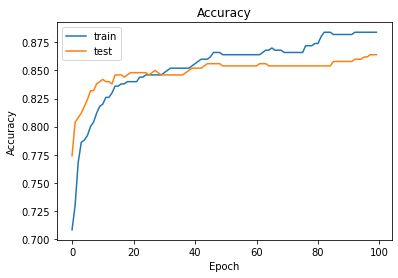

Accuracy:  0.8613


0.8613

In [ ]:
mini_batch_size = 200
epoch_number = 75
numHiddenLayers = 2
HIDDEN_SIZE = 128

inputSize = X_train.shape[1]
outputSize = y_train.shape[1]
model = MLP("leaky_relu", numHiddenLayers , HIDDEN_SIZE, inputSize, outputSize, epoch_number, mini_batch_size)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
model.evaluate_acc(y_test, y_pred)

In [ ]:
leakyrelu_acc = 0.8613

### Tanh

  1%|          | 1/100 [00:24<41:00, 24.86s/it]

Accuracy:  0.712


  2%|▏         | 2/100 [00:49<40:33, 24.83s/it]

Accuracy:  0.73


  3%|▎         | 3/100 [01:14<40:09, 24.84s/it]

Accuracy:  0.756


  4%|▍         | 4/100 [01:39<39:39, 24.78s/it]

Accuracy:  0.774


  5%|▌         | 5/100 [02:03<39:13, 24.77s/it]

Accuracy:  0.792


  6%|▌         | 6/100 [02:29<39:08, 24.98s/it]

Accuracy:  0.8


  7%|▋         | 7/100 [02:54<38:36, 24.90s/it]

Accuracy:  0.814


  8%|▊         | 8/100 [03:18<38:06, 24.85s/it]

Accuracy:  0.808


  9%|▉         | 9/100 [03:43<37:37, 24.81s/it]

Accuracy:  0.814


 10%|█         | 10/100 [04:08<37:10, 24.79s/it]

Accuracy:  0.82


 11%|█         | 11/100 [04:32<36:42, 24.75s/it]

Accuracy:  0.82


 12%|█▏        | 12/100 [04:58<36:31, 24.90s/it]

Accuracy:  0.818


 13%|█▎        | 13/100 [05:22<36:01, 24.85s/it]

Accuracy:  0.82


 14%|█▍        | 14/100 [05:47<35:32, 24.80s/it]

Accuracy:  0.82


 15%|█▌        | 15/100 [06:12<35:08, 24.81s/it]

Accuracy:  0.82


 16%|█▌        | 16/100 [06:37<34:41, 24.78s/it]

Accuracy:  0.824


 17%|█▋        | 17/100 [07:01<34:14, 24.75s/it]

Accuracy:  0.824


 18%|█▊        | 18/100 [07:27<34:02, 24.90s/it]

Accuracy:  0.824


 19%|█▉        | 19/100 [07:51<33:33, 24.86s/it]

Accuracy:  0.83


 20%|██        | 20/100 [08:16<33:03, 24.79s/it]

Accuracy:  0.832


 21%|██        | 21/100 [08:41<32:37, 24.78s/it]

Accuracy:  0.834


 22%|██▏       | 22/100 [09:05<32:10, 24.76s/it]

Accuracy:  0.836


 23%|██▎       | 23/100 [09:30<31:43, 24.72s/it]

Accuracy:  0.836


 24%|██▍       | 24/100 [09:55<31:17, 24.71s/it]

Accuracy:  0.836


 25%|██▌       | 25/100 [10:20<31:05, 24.87s/it]

Accuracy:  0.836


 26%|██▌       | 26/100 [10:45<30:38, 24.85s/it]

Accuracy:  0.836


 27%|██▋       | 27/100 [11:10<30:12, 24.83s/it]

Accuracy:  0.836


 28%|██▊       | 28/100 [11:34<29:44, 24.78s/it]

Accuracy:  0.836


 29%|██▉       | 29/100 [11:59<29:18, 24.76s/it]

Accuracy:  0.838


 30%|███       | 30/100 [12:24<28:50, 24.72s/it]

Accuracy:  0.84


 31%|███       | 31/100 [12:49<28:36, 24.88s/it]

Accuracy:  0.84


 32%|███▏      | 32/100 [13:14<28:08, 24.83s/it]

Accuracy:  0.84


 33%|███▎      | 33/100 [13:38<27:41, 24.81s/it]

Accuracy:  0.84


 34%|███▍      | 34/100 [14:03<27:15, 24.77s/it]

Accuracy:  0.842


 35%|███▌      | 35/100 [14:28<26:46, 24.72s/it]

Accuracy:  0.842


 36%|███▌      | 36/100 [14:52<26:20, 24.70s/it]

Accuracy:  0.844


 37%|███▋      | 37/100 [15:18<26:08, 24.90s/it]

Accuracy:  0.842


 38%|███▊      | 38/100 [15:42<25:42, 24.88s/it]

Accuracy:  0.842


 39%|███▉      | 39/100 [16:07<25:15, 24.85s/it]

Accuracy:  0.842


 40%|████      | 40/100 [16:32<24:49, 24.82s/it]

Accuracy:  0.844


 41%|████      | 41/100 [16:57<24:22, 24.79s/it]

Accuracy:  0.848


 42%|████▏     | 42/100 [17:21<23:55, 24.75s/it]

Accuracy:  0.848


 43%|████▎     | 43/100 [17:47<23:37, 24.87s/it]

Accuracy:  0.848


 44%|████▍     | 44/100 [18:11<23:08, 24.79s/it]

Accuracy:  0.85


 45%|████▌     | 45/100 [18:36<22:41, 24.76s/it]

Accuracy:  0.854


 46%|████▌     | 46/100 [19:01<22:16, 24.76s/it]

Accuracy:  0.856


 47%|████▋     | 47/100 [19:25<21:49, 24.71s/it]

Accuracy:  0.856


 48%|████▊     | 48/100 [19:50<21:23, 24.68s/it]

Accuracy:  0.856


 49%|████▉     | 49/100 [20:15<21:08, 24.88s/it]

Accuracy:  0.856


 50%|█████     | 50/100 [20:40<20:43, 24.86s/it]

Accuracy:  0.858


 51%|█████     | 51/100 [21:05<20:16, 24.83s/it]

Accuracy:  0.86


 52%|█████▏    | 52/100 [21:29<19:49, 24.78s/it]

Accuracy:  0.862


 53%|█████▎    | 53/100 [21:54<19:23, 24.76s/it]

Accuracy:  0.862


 54%|█████▍    | 54/100 [22:19<18:57, 24.72s/it]

Accuracy:  0.862


 55%|█████▌    | 55/100 [22:43<18:32, 24.71s/it]

Accuracy:  0.862


 56%|█████▌    | 56/100 [23:09<18:15, 24.90s/it]

Accuracy:  0.862


 57%|█████▋    | 57/100 [23:33<17:46, 24.79s/it]

Accuracy:  0.864


 58%|█████▊    | 58/100 [23:58<17:19, 24.74s/it]

Accuracy:  0.864


 59%|█████▉    | 59/100 [24:23<16:53, 24.71s/it]

Accuracy:  0.864


 60%|██████    | 60/100 [24:47<16:27, 24.69s/it]

Accuracy:  0.864


 61%|██████    | 61/100 [25:12<16:03, 24.70s/it]

Accuracy:  0.864


 62%|██████▏   | 62/100 [25:37<15:44, 24.85s/it]

Accuracy:  0.866


 63%|██████▎   | 63/100 [26:02<15:18, 24.81s/it]

Accuracy:  0.866


 64%|██████▍   | 64/100 [26:26<14:51, 24.76s/it]

Accuracy:  0.866


 65%|██████▌   | 65/100 [26:51<14:25, 24.72s/it]

Accuracy:  0.866


 66%|██████▌   | 66/100 [27:16<14:01, 24.75s/it]

Accuracy:  0.866


 67%|██████▋   | 67/100 [27:41<13:35, 24.72s/it]

Accuracy:  0.868


 68%|██████▊   | 68/100 [28:06<13:17, 24.92s/it]

Accuracy:  0.868


 69%|██████▉   | 69/100 [28:31<12:50, 24.86s/it]

Accuracy:  0.87


 70%|███████   | 70/100 [28:55<12:24, 24.82s/it]

Accuracy:  0.87


 71%|███████   | 71/100 [29:20<11:57, 24.76s/it]

Accuracy:  0.87


 72%|███████▏  | 72/100 [29:45<11:32, 24.74s/it]

Accuracy:  0.87


 73%|███████▎  | 73/100 [30:10<11:08, 24.75s/it]

Accuracy:  0.87


 74%|███████▍  | 74/100 [30:35<10:49, 24.97s/it]

Accuracy:  0.87


 75%|███████▌  | 75/100 [31:00<10:22, 24.90s/it]

Accuracy:  0.87


 76%|███████▌  | 76/100 [31:24<09:52, 24.71s/it]

Accuracy:  0.876


 77%|███████▋  | 77/100 [31:48<09:25, 24.57s/it]

Accuracy:  0.878


 78%|███████▊  | 78/100 [32:12<08:58, 24.47s/it]

Accuracy:  0.878


 79%|███████▉  | 79/100 [32:37<08:32, 24.40s/it]

Accuracy:  0.88


 80%|████████  | 80/100 [33:02<08:10, 24.54s/it]

Accuracy:  0.88


 81%|████████  | 81/100 [33:26<07:44, 24.45s/it]

Accuracy:  0.882


 82%|████████▏ | 82/100 [33:50<07:18, 24.38s/it]

Accuracy:  0.884


 83%|████████▎ | 83/100 [34:14<06:53, 24.34s/it]

Accuracy:  0.884


 84%|████████▍ | 84/100 [34:39<06:29, 24.33s/it]

Accuracy:  0.884


 85%|████████▌ | 85/100 [35:03<06:05, 24.33s/it]

Accuracy:  0.884


 86%|████████▌ | 86/100 [35:28<05:42, 24.47s/it]

Accuracy:  0.884


 87%|████████▋ | 87/100 [35:52<05:17, 24.41s/it]

Accuracy:  0.884


 88%|████████▊ | 88/100 [36:16<04:52, 24.38s/it]

Accuracy:  0.884


 89%|████████▉ | 89/100 [36:40<04:27, 24.32s/it]

Accuracy:  0.884


 90%|█████████ | 90/100 [37:05<04:03, 24.31s/it]

Accuracy:  0.884


 91%|█████████ | 91/100 [37:29<03:38, 24.28s/it]

Accuracy:  0.884


 92%|█████████▏| 92/100 [37:53<03:14, 24.25s/it]

Accuracy:  0.884


 93%|█████████▎| 93/100 [38:18<02:51, 24.44s/it]

Accuracy:  0.882


 94%|█████████▍| 94/100 [38:42<02:26, 24.40s/it]

Accuracy:  0.882


 95%|█████████▌| 95/100 [39:07<02:01, 24.37s/it]

Accuracy:  0.882


 96%|█████████▌| 96/100 [39:31<01:37, 24.33s/it]

Accuracy:  0.882


 97%|█████████▋| 97/100 [39:55<01:12, 24.32s/it]

Accuracy:  0.884


 98%|█████████▊| 98/100 [40:20<00:48, 24.33s/it]

Accuracy:  0.886


 99%|█████████▉| 99/100 [40:44<00:24, 24.50s/it]

Accuracy:  0.886


100%|██████████| 100/100 [41:09<00:00, 24.69s/it]

Accuracy:  0.886


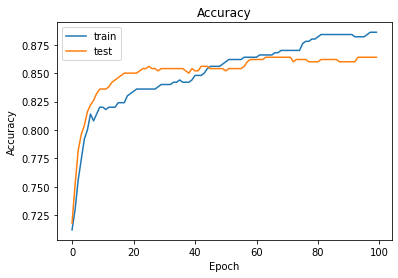

Accuracy:  0.8598


0.8598

In [ ]:
mini_batch_size = 200
epoch_number = 75
numHiddenLayers = 2
HIDDEN_SIZE = 128

inputSize = X_train.shape[1]
outputSize = y_train.shape[1]
model = MLP("tanh", numHiddenLayers , HIDDEN_SIZE, inputSize, outputSize, epoch_number, mini_batch_size)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
model.evaluate_acc(y_test, y_pred)

In [ ]:
tanh_acc = 0.8598

## 3) L2 Regularization
We add weight penalties to weights that are too large. We force them to be smaller than they are otherwise.

  1%|          | 1/100 [00:23<39:06, 23.70s/it]

Accuracy:  0.778


  2%|▏         | 2/100 [00:47<38:29, 23.56s/it]

Accuracy:  0.814


  3%|▎         | 3/100 [01:10<38:01, 23.52s/it]

Accuracy:  0.828


  4%|▍         | 4/100 [01:34<37:37, 23.52s/it]

Accuracy:  0.842


  5%|▌         | 5/100 [01:58<37:35, 23.74s/it]

Accuracy:  0.842


  6%|▌         | 6/100 [02:21<37:04, 23.67s/it]

Accuracy:  0.848


  7%|▋         | 7/100 [02:45<36:36, 23.62s/it]

Accuracy:  0.85


  8%|▊         | 8/100 [03:08<36:08, 23.57s/it]

Accuracy:  0.862


  9%|▉         | 9/100 [03:32<35:44, 23.56s/it]

Accuracy:  0.864


 10%|█         | 10/100 [03:55<35:18, 23.54s/it]

Accuracy:  0.866


 11%|█         | 11/100 [04:19<34:55, 23.54s/it]

Accuracy:  0.866


 12%|█▏        | 12/100 [04:43<34:48, 23.73s/it]

Accuracy:  0.866


 13%|█▎        | 13/100 [05:07<34:18, 23.67s/it]

Accuracy:  0.868


 14%|█▍        | 14/100 [05:30<33:50, 23.62s/it]

Accuracy:  0.872


 15%|█▌        | 15/100 [05:54<33:25, 23.59s/it]

Accuracy:  0.872


 16%|█▌        | 16/100 [06:17<32:57, 23.54s/it]

Accuracy:  0.872


 17%|█▋        | 17/100 [06:41<32:33, 23.53s/it]

Accuracy:  0.872


 18%|█▊        | 18/100 [07:05<32:25, 23.73s/it]

Accuracy:  0.872


 19%|█▉        | 19/100 [07:28<31:55, 23.65s/it]

Accuracy:  0.872


 20%|██        | 20/100 [07:52<31:28, 23.61s/it]

Accuracy:  0.874


 21%|██        | 21/100 [08:15<31:02, 23.58s/it]

Accuracy:  0.874


 22%|██▏       | 22/100 [08:39<30:36, 23.55s/it]

Accuracy:  0.878


 23%|██▎       | 23/100 [09:02<30:12, 23.54s/it]

Accuracy:  0.88


 24%|██▍       | 24/100 [09:26<30:04, 23.74s/it]

Accuracy:  0.882


 25%|██▌       | 25/100 [09:50<29:37, 23.70s/it]

Accuracy:  0.888


 26%|██▌       | 26/100 [10:14<29:09, 23.65s/it]

Accuracy:  0.888


 27%|██▋       | 27/100 [10:37<28:42, 23.60s/it]

Accuracy:  0.894


 28%|██▊       | 28/100 [11:01<28:17, 23.58s/it]

Accuracy:  0.894


 29%|██▉       | 29/100 [11:24<27:52, 23.56s/it]

Accuracy:  0.896


 30%|███       | 30/100 [11:48<27:29, 23.57s/it]

Accuracy:  0.9


 31%|███       | 31/100 [12:12<27:17, 23.73s/it]

Accuracy:  0.902


 32%|███▏      | 32/100 [12:35<26:49, 23.67s/it]

Accuracy:  0.902


 33%|███▎      | 33/100 [12:59<26:21, 23.61s/it]

Accuracy:  0.898


 34%|███▍      | 34/100 [13:22<25:56, 23.58s/it]

Accuracy:  0.9


 35%|███▌      | 35/100 [13:46<25:33, 23.59s/it]

Accuracy:  0.9


 36%|███▌      | 36/100 [14:09<25:09, 23.59s/it]

Accuracy:  0.9


 37%|███▋      | 37/100 [14:34<24:56, 23.76s/it]

Accuracy:  0.9


 38%|███▊      | 38/100 [14:57<24:30, 23.72s/it]

Accuracy:  0.898


 39%|███▉      | 39/100 [15:21<24:08, 23.74s/it]

Accuracy:  0.898


 40%|████      | 40/100 [15:45<23:45, 23.75s/it]

Accuracy:  0.9


 41%|████      | 41/100 [16:09<23:21, 23.75s/it]

Accuracy:  0.902


 42%|████▏     | 42/100 [16:32<22:56, 23.73s/it]

Accuracy:  0.904


 43%|████▎     | 43/100 [16:57<22:44, 23.94s/it]

Accuracy:  0.902


 44%|████▍     | 44/100 [17:20<22:17, 23.88s/it]

Accuracy:  0.902


 45%|████▌     | 45/100 [17:44<21:51, 23.85s/it]

Accuracy:  0.904


 46%|████▌     | 46/100 [18:08<21:24, 23.78s/it]

Accuracy:  0.904


 47%|████▋     | 47/100 [18:32<20:58, 23.75s/it]

Accuracy:  0.906


 48%|████▊     | 48/100 [18:55<20:35, 23.75s/it]

Accuracy:  0.906


 49%|████▉     | 49/100 [19:19<20:12, 23.77s/it]

Accuracy:  0.906


 50%|█████     | 50/100 [19:43<19:57, 23.96s/it]

Accuracy:  0.908


 51%|█████     | 51/100 [20:07<19:30, 23.89s/it]

Accuracy:  0.908


 52%|█████▏    | 52/100 [20:31<19:04, 23.85s/it]

Accuracy:  0.908


 53%|█████▎    | 53/100 [20:55<18:39, 23.81s/it]

Accuracy:  0.908


 54%|█████▍    | 54/100 [21:18<18:13, 23.77s/it]

Accuracy:  0.908


 55%|█████▌    | 55/100 [21:42<17:49, 23.77s/it]

Accuracy:  0.91


 56%|█████▌    | 56/100 [22:06<17:32, 23.91s/it]

Accuracy:  0.91


 57%|█████▋    | 57/100 [22:30<17:02, 23.79s/it]

Accuracy:  0.91


 58%|█████▊    | 58/100 [22:53<16:35, 23.71s/it]

Accuracy:  0.91


 59%|█████▉    | 59/100 [23:17<16:10, 23.67s/it]

Accuracy:  0.912


 60%|██████    | 60/100 [23:41<15:46, 23.65s/it]

Accuracy:  0.914


 61%|██████    | 61/100 [24:04<15:21, 23.63s/it]

Accuracy:  0.916


 62%|██████▏   | 62/100 [24:28<14:57, 23.63s/it]

Accuracy:  0.916


 63%|██████▎   | 63/100 [24:52<14:40, 23.80s/it]

Accuracy:  0.918


 64%|██████▍   | 64/100 [25:16<14:14, 23.72s/it]

Accuracy:  0.92


 65%|██████▌   | 65/100 [25:39<13:47, 23.66s/it]

Accuracy:  0.922


 66%|██████▌   | 66/100 [26:03<13:23, 23.62s/it]

Accuracy:  0.92


 67%|██████▋   | 67/100 [26:26<12:57, 23.56s/it]

Accuracy:  0.922


 68%|██████▊   | 68/100 [26:49<12:33, 23.53s/it]

Accuracy:  0.92


 69%|██████▉   | 69/100 [27:14<12:15, 23.72s/it]

Accuracy:  0.924


 70%|███████   | 70/100 [27:37<11:51, 23.70s/it]

Accuracy:  0.924


 71%|███████   | 71/100 [28:01<11:25, 23.65s/it]

Accuracy:  0.924


 72%|███████▏  | 72/100 [28:24<11:00, 23.59s/it]

Accuracy:  0.926


 73%|███████▎  | 73/100 [28:48<10:37, 23.60s/it]

Accuracy:  0.928


 74%|███████▍  | 74/100 [29:12<10:13, 23.60s/it]

Accuracy:  0.928


 75%|███████▌  | 75/100 [29:35<09:50, 23.63s/it]

Accuracy:  0.928


 76%|███████▌  | 76/100 [29:59<09:31, 23.81s/it]

Accuracy:  0.928


 77%|███████▋  | 77/100 [30:23<09:05, 23.72s/it]

Accuracy:  0.928


 78%|███████▊  | 78/100 [30:47<08:41, 23.69s/it]

Accuracy:  0.926


 79%|███████▉  | 79/100 [31:10<08:16, 23.62s/it]

Accuracy:  0.928


 80%|████████  | 80/100 [31:34<07:51, 23.60s/it]

Accuracy:  0.928


 81%|████████  | 81/100 [31:57<07:28, 23.58s/it]

Accuracy:  0.93


 82%|████████▏ | 82/100 [32:21<07:07, 23.75s/it]

Accuracy:  0.926


 83%|████████▎ | 83/100 [32:45<06:42, 23.70s/it]

Accuracy:  0.926


 84%|████████▍ | 84/100 [33:08<06:17, 23.62s/it]

Accuracy:  0.926


 85%|████████▌ | 85/100 [33:32<05:54, 23.61s/it]

Accuracy:  0.926


 86%|████████▌ | 86/100 [33:55<05:30, 23.60s/it]

Accuracy:  0.926


 87%|████████▋ | 87/100 [34:19<05:06, 23.60s/it]

Accuracy:  0.928


 88%|████████▊ | 88/100 [34:43<04:43, 23.59s/it]

Accuracy:  0.93


 89%|████████▉ | 89/100 [35:07<04:21, 23.81s/it]

Accuracy:  0.93


 90%|█████████ | 90/100 [35:31<03:57, 23.74s/it]

Accuracy:  0.93


 91%|█████████ | 91/100 [35:54<03:33, 23.69s/it]

Accuracy:  0.932


 92%|█████████▏| 92/100 [36:18<03:09, 23.64s/it]

Accuracy:  0.934


 93%|█████████▎| 93/100 [36:41<02:45, 23.60s/it]

Accuracy:  0.932


 94%|█████████▍| 94/100 [37:05<02:21, 23.57s/it]

Accuracy:  0.934


 95%|█████████▌| 95/100 [37:29<01:58, 23.73s/it]

Accuracy:  0.934


 96%|█████████▌| 96/100 [37:52<01:34, 23.69s/it]

Accuracy:  0.934


 97%|█████████▋| 97/100 [38:16<01:10, 23.63s/it]

Accuracy:  0.932


 98%|█████████▊| 98/100 [38:39<00:47, 23.57s/it]

Accuracy:  0.932


 99%|█████████▉| 99/100 [39:03<00:23, 23.54s/it]

Accuracy:  0.932


100%|██████████| 100/100 [39:26<00:00, 23.67s/it]

Accuracy:  0.932


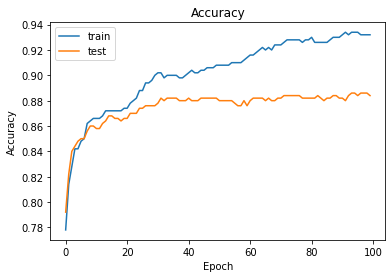

Accuracy:  0.8803


0.8803

In [ ]:
mini_batch_size = 200
epoch_number = 75
numHiddenLayers = 2
HIDDEN_SIZE = 128
# Set to 2 cuz best results in experiments
lmbd = 2

inputSize = X_train.shape[1]
outputSize = y_train.shape[1]
model = MLP("relu", numHiddenLayers , HIDDEN_SIZE, inputSize, outputSize, epoch_number, mini_batch_size, regularization=True, lmbd=lmbd)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
model.evaluate_acc(y_test, y_pred)

In [ ]:
# Lambda = 2
reg_acc1 = 0.8803
# Lambda = 4
reg_acc2 = 0.8683
# Lamda = 1
reg_acc3 = 0.8684
# Lambda 0.5
reg_acc4 = 0.8636
# Lambda 0.1
reg_acc5 = 0.8588
# Lambda 0.01
reg_acc6 = 0.8546
# Lambda 0.001
reg_acc7 = 0.8548

  1%|          | 1/100 [00:24<41:02, 24.88s/it]

Accuracy:  0.78


  2%|▏         | 2/100 [00:50<41:11, 25.22s/it]

Accuracy:  0.812


  3%|▎         | 3/100 [01:15<40:22, 24.98s/it]

Accuracy:  0.82


  4%|▍         | 4/100 [01:39<39:46, 24.86s/it]

Accuracy:  0.828


  5%|▌         | 5/100 [02:04<39:15, 24.80s/it]

Accuracy:  0.834


  6%|▌         | 6/100 [02:29<38:49, 24.79s/it]

Accuracy:  0.84


  7%|▋         | 7/100 [02:53<38:22, 24.76s/it]

Accuracy:  0.84


  8%|▊         | 8/100 [03:19<38:14, 24.94s/it]

Accuracy:  0.842


  9%|▉         | 9/100 [03:43<37:41, 24.85s/it]

Accuracy:  0.848


 10%|█         | 10/100 [04:08<37:13, 24.81s/it]

Accuracy:  0.85


 11%|█         | 11/100 [04:33<36:43, 24.76s/it]

Accuracy:  0.85


 12%|█▏        | 12/100 [04:58<36:20, 24.78s/it]

Accuracy:  0.852


 13%|█▎        | 13/100 [05:22<35:54, 24.77s/it]

Accuracy:  0.858


 14%|█▍        | 14/100 [05:48<35:48, 24.98s/it]

Accuracy:  0.862


 15%|█▌        | 15/100 [06:13<35:19, 24.94s/it]

Accuracy:  0.862


 16%|█▌        | 16/100 [06:37<34:51, 24.90s/it]

Accuracy:  0.862


 17%|█▋        | 17/100 [07:02<34:20, 24.82s/it]

Accuracy:  0.864


 18%|█▊        | 18/100 [07:27<33:53, 24.80s/it]

Accuracy:  0.866


 19%|█▉        | 19/100 [07:51<33:26, 24.77s/it]

Accuracy:  0.87


 20%|██        | 20/100 [08:16<33:02, 24.78s/it]

Accuracy:  0.872


 21%|██        | 21/100 [08:42<32:50, 24.94s/it]

Accuracy:  0.874


 22%|██▏       | 22/100 [09:06<32:19, 24.87s/it]

Accuracy:  0.876


 23%|██▎       | 23/100 [09:31<31:52, 24.83s/it]

Accuracy:  0.88


 24%|██▍       | 24/100 [09:56<31:27, 24.83s/it]

Accuracy:  0.88


 25%|██▌       | 25/100 [10:21<31:02, 24.83s/it]

Accuracy:  0.882


 26%|██▌       | 26/100 [10:46<30:36, 24.81s/it]

Accuracy:  0.884


 27%|██▋       | 27/100 [11:11<30:23, 24.98s/it]

Accuracy:  0.884


 28%|██▊       | 28/100 [11:36<29:51, 24.88s/it]

Accuracy:  0.888


 29%|██▉       | 29/100 [12:00<29:20, 24.80s/it]

Accuracy:  0.888


 30%|███       | 30/100 [12:25<28:55, 24.79s/it]

Accuracy:  0.888


 31%|███       | 31/100 [12:50<28:28, 24.77s/it]

Accuracy:  0.894


 32%|███▏      | 32/100 [13:14<28:02, 24.74s/it]

Accuracy:  0.894


 33%|███▎      | 33/100 [13:40<27:47, 24.89s/it]

Accuracy:  0.894


 34%|███▍      | 34/100 [14:04<27:20, 24.86s/it]

Accuracy:  0.892


 35%|███▌      | 35/100 [14:29<26:53, 24.83s/it]

Accuracy:  0.892


 36%|███▌      | 36/100 [14:54<26:28, 24.82s/it]

Accuracy:  0.898


 37%|███▋      | 37/100 [15:19<26:02, 24.80s/it]

Accuracy:  0.898


 38%|███▊      | 38/100 [15:43<25:38, 24.81s/it]

Accuracy:  0.898


 39%|███▉      | 39/100 [16:08<25:15, 24.84s/it]

Accuracy:  0.898


 40%|████      | 40/100 [16:34<25:04, 25.07s/it]

Accuracy:  0.9


 41%|████      | 41/100 [16:59<24:34, 24.99s/it]

Accuracy:  0.902


 42%|████▏     | 42/100 [17:24<24:08, 24.97s/it]

Accuracy:  0.902


 43%|████▎     | 43/100 [17:49<23:41, 24.95s/it]

Accuracy:  0.904


 44%|████▍     | 44/100 [18:13<23:15, 24.93s/it]

Accuracy:  0.904


 45%|████▌     | 45/100 [18:39<22:52, 24.95s/it]

Accuracy:  0.906


 46%|████▌     | 46/100 [19:04<22:38, 25.16s/it]

Accuracy:  0.906


 47%|████▋     | 47/100 [19:29<22:12, 25.14s/it]

Accuracy:  0.906


 48%|████▊     | 48/100 [19:54<21:47, 25.15s/it]

Accuracy:  0.908


 49%|████▉     | 49/100 [20:20<21:22, 25.14s/it]

Accuracy:  0.908


 50%|█████     | 50/100 [20:45<20:55, 25.11s/it]

Accuracy:  0.908


 51%|█████     | 51/100 [21:10<20:27, 25.06s/it]

Accuracy:  0.908


 52%|█████▏    | 52/100 [21:35<20:02, 25.04s/it]

Accuracy:  0.908


 53%|█████▎    | 53/100 [22:00<19:44, 25.21s/it]

Accuracy:  0.908


 54%|█████▍    | 54/100 [22:25<19:17, 25.16s/it]

Accuracy:  0.912


 55%|█████▌    | 55/100 [22:50<18:47, 25.06s/it]

Accuracy:  0.908


 56%|█████▌    | 56/100 [23:15<18:22, 25.06s/it]

Accuracy:  0.908


 57%|█████▋    | 57/100 [23:40<17:56, 25.03s/it]

Accuracy:  0.908


 58%|█████▊    | 58/100 [24:05<17:30, 25.01s/it]

Accuracy:  0.91


 59%|█████▉    | 59/100 [24:31<17:12, 25.19s/it]

Accuracy:  0.91


 60%|██████    | 60/100 [24:56<16:45, 25.14s/it]

Accuracy:  0.91


 61%|██████    | 61/100 [25:21<16:19, 25.11s/it]

Accuracy:  0.912


 62%|██████▏   | 62/100 [25:46<15:54, 25.11s/it]

Accuracy:  0.912


 63%|██████▎   | 63/100 [26:11<15:28, 25.09s/it]

Accuracy:  0.914


 64%|██████▍   | 64/100 [26:36<15:01, 25.03s/it]

Accuracy:  0.914


 65%|██████▌   | 65/100 [27:01<14:34, 24.99s/it]

Accuracy:  0.918


 66%|██████▌   | 66/100 [27:26<14:15, 25.17s/it]

Accuracy:  0.918


 67%|██████▋   | 67/100 [27:51<13:47, 25.08s/it]

Accuracy:  0.918


 68%|██████▊   | 68/100 [28:16<13:21, 25.04s/it]

Accuracy:  0.918


 69%|██████▉   | 69/100 [28:41<12:55, 25.01s/it]

Accuracy:  0.918


 70%|███████   | 70/100 [29:06<12:30, 25.02s/it]

Accuracy:  0.918


 71%|███████   | 71/100 [29:31<12:06, 25.07s/it]

Accuracy:  0.918


 72%|███████▏  | 72/100 [29:57<11:49, 25.33s/it]

Accuracy:  0.918


 73%|███████▎  | 73/100 [30:22<11:23, 25.31s/it]

Accuracy:  0.92


 74%|███████▍  | 74/100 [30:48<10:57, 25.29s/it]

Accuracy:  0.92


 75%|███████▌  | 75/100 [31:13<10:31, 25.24s/it]

Accuracy:  0.92


 76%|███████▌  | 76/100 [31:38<10:04, 25.19s/it]

Accuracy:  0.92


 77%|███████▋  | 77/100 [32:03<09:39, 25.20s/it]

Accuracy:  0.92


 78%|███████▊  | 78/100 [32:28<09:14, 25.23s/it]

Accuracy:  0.922


 79%|███████▉  | 79/100 [32:54<08:52, 25.38s/it]

Accuracy:  0.922


 80%|████████  | 80/100 [33:19<08:26, 25.30s/it]

Accuracy:  0.924


 81%|████████  | 81/100 [33:44<07:59, 25.26s/it]

Accuracy:  0.924


 82%|████████▏ | 82/100 [34:10<07:34, 25.26s/it]

Accuracy:  0.924


 83%|████████▎ | 83/100 [34:35<07:08, 25.22s/it]

Accuracy:  0.924


 84%|████████▍ | 84/100 [35:00<06:43, 25.22s/it]

Accuracy:  0.924


 85%|████████▌ | 85/100 [35:26<06:21, 25.43s/it]

Accuracy:  0.924


 86%|████████▌ | 86/100 [35:51<05:54, 25.35s/it]

Accuracy:  0.924


 87%|████████▋ | 87/100 [36:16<05:28, 25.30s/it]

Accuracy:  0.924


 88%|████████▊ | 88/100 [36:42<05:03, 25.30s/it]

Accuracy:  0.924


 89%|████████▉ | 89/100 [37:07<04:37, 25.22s/it]

Accuracy:  0.926


 90%|█████████ | 90/100 [37:32<04:12, 25.20s/it]

Accuracy:  0.926


 91%|█████████ | 91/100 [37:57<03:46, 25.13s/it]

Accuracy:  0.926


 92%|█████████▏| 92/100 [38:22<03:22, 25.26s/it]

Accuracy:  0.928


 93%|█████████▎| 93/100 [38:47<02:56, 25.15s/it]

Accuracy:  0.928


 94%|█████████▍| 94/100 [39:12<02:30, 25.05s/it]

Accuracy:  0.93


 95%|█████████▌| 95/100 [39:37<02:05, 25.01s/it]

Accuracy:  0.93


 96%|█████████▌| 96/100 [40:02<01:40, 25.02s/it]

Accuracy:  0.932


 97%|█████████▋| 97/100 [40:27<01:14, 24.99s/it]

Accuracy:  0.932


 98%|█████████▊| 98/100 [40:52<00:50, 25.16s/it]

Accuracy:  0.932


 99%|█████████▉| 99/100 [41:17<00:25, 25.07s/it]

Accuracy:  0.932


100%|██████████| 100/100 [41:42<00:00, 25.03s/it]

Accuracy:  0.932


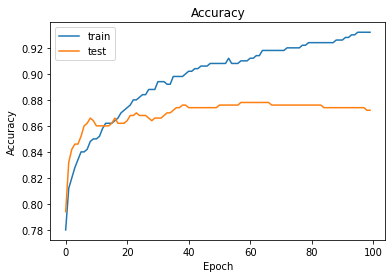

Accuracy:  0.8808


0.8808

In [ ]:
mini_batch_size = 200
epoch_number = 75
numHiddenLayers = 2
HIDDEN_SIZE = 128
lmbd = 2

inputSize = X_train.shape[1]
outputSize = y_train.shape[1]
model = MLP("tanh", numHiddenLayers , HIDDEN_SIZE, inputSize, outputSize, epoch_number, mini_batch_size, regularization=True, lmbd=lmbd)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
model.evaluate_acc(y_test, y_pred)

In [ ]:
tanh_regularized_acc = 0.8808

  0%|          | 0/75 [00:00<?, ?it/s]

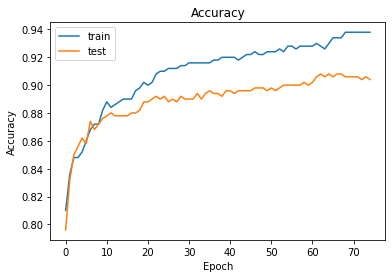

Accuracy:  0.8759


0.8759

In [ ]:
mini_batch_size = 200
epoch_number = 75
numHiddenLayers = 2
HIDDEN_SIZE = 128
lmbd = 2

inputSize = X_train.shape[1]
outputSize = y_train.shape[1]
model = MLP("leaky_relu", numHiddenLayers , HIDDEN_SIZE, inputSize, outputSize, epoch_number, mini_batch_size, regularization=True, lmbd=lmbd)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
model.evaluate_acc(y_test, y_pred)

In [ ]:
leaky_relu_regularized = 0.8759

## 4) Not Normalized 

* We initially had a numerical issue (probably divide by 0). For some reason, we don't have this issue with X_train & X_test. Upon inspection, the normalization converted all ints to floats (so, 0 becomes 0.). I therefore divided the ..._not_normalized arrays by 1 to resolve this issue. Unsure why this causes a problem though. 
* As expected, working with non normalized data significantly impacts performance. An accuracy of 0.1 is equivalent to randomly guessing (since there are 10 classes), and that is what our model effectively ends up doing. 
* This could be explained by the fact that, since there is a much larger range of values, the gradient calculations vary enormously from one neuron to the next and 

In [ ]:
mini_batch_size = 200
epoch_number = 20
numHiddenLayers = 2
HIDDEN_SIZE = 128

inputSize = X_train_not_normalized.shape[1]
outputSize = y_train.shape[1]
model = MLP("relu", numHiddenLayers, HIDDEN_SIZE, inputSize, outputSize, epoch_number, mini_batch_size)

model.fit(X_train_not_normalized, y_train)

y_pred = model.predict(X_test_not_normalized)
model.evaluate_acc(y_test, y_pred)

In [ ]:
notnormalized_acc = 0.1

## 5) ConvNet with Keras

NOTE: PORTIONS ARE COMMENTED OUT TO PREVENT IT FROM RUNNING WITH EVERY RUN. convnet_acc HAS BEEN SAVED SEPARATELY SO IT'S USABLE/VISIBLE. 

[Used guide by Rutvik Deshpande](https://www.kaggle.com/code/rutvikdeshpande/fashion-mnist-cnn-beginner-98/notebook)

**Notes on Model Design**
*   Used GPU acceleration (Runtime->Change runtime type) for much faster training
*   Rutvik's model design provides improved performance on test data thanks to layers that help prevent overfitting (in particular multiple Dropout layers to prevent over-reliance on specific neurons, including in the fully connected classification portion of the model)
*   It also makes use of multiple BatchNormalization layers as a way of reducing sensitivity to the learning rate (though ADAM is used, which is already a great option) & reduced gradient explosion (though there aren't too many connected layers, meaning the risk of this is lowered).

**Notes on Results**
*    With GPU acceleration, it still took 6m 23s to train due to the high number of epochs (100)
*    Test accuracy: 0.9722; validation accuracy: 0.9345
*    As the test accuracy < 1, this indicates that our model does not overfit
*    convnet_acc = 0.9297999739646912. A pretty decent classification accuracy on the testing set. 
*    This clearly outperforms the MLP's best accuracies we could get by a lot. This makes sense since ConvNets are specially adapted to better handling image inputs by performing convolution as a way of extracting more meaningful image features. Additionally, this model is a lot more complex and contains a lot more layers for improved feature abstraction, which is possible given Keras's GPU optimizations (for our MLP, creating more complex models would create for much too slow training times). 

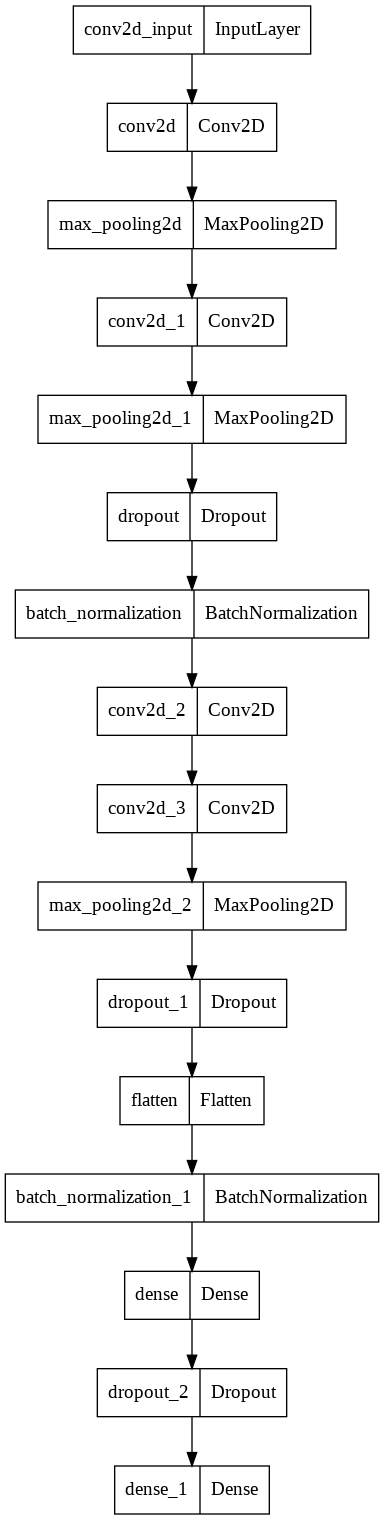

In [ ]:
model = Sequential([
  Conv2D(32, 3, padding='same', activation='relu',kernel_initializer='he_normal', input_shape=(28,28, 1)),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.3),
  BatchNormalization(),
  Conv2D(128, 3, padding='same', activation='relu'),
  Conv2D(128, 3, padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.4),
  Flatten(),
  BatchNormalization(),
  Dense(512, activation='relu'),
  Dropout(0.25),
  Dense(10, activation='softmax')
])

plot_model(model, to_file="convnet.png")

In [ ]:
# Takes 6m 23s to run with GPU acceleration, so commented out & saved accuracy

model.compile(
    'adam',
    loss=categorical_crossentropy,
    metrics=['accuracy']
)

train_model = model.fit(X_train_w_val, to_categorical(y_train_w_val),
                        batch_size = 128,
                        epochs = 100,
                        verbose=1,
                        validation_data=(X_val, to_categorical(y_val)))

Epoch 1/100
375/375 [==============================] - 13s 9ms/step - loss: 0.5621 - accuracy: 0.7989 - val_loss: 0.4068 - val_accuracy: 0.8472
Epoch 2/100
375/375 [==============================] - 3s 8ms/step - loss: 0.3847 - accuracy: 0.8592 - val_loss: 0.3007 - val_accuracy: 0.8870
Epoch 3/100
375/375 [==============================] - 3s 8ms/step - loss: 0.3316 - accuracy: 0.8780 - val_loss: 0.3393 - val_accuracy: 0.8736
Epoch 4/100
375/375 [==============================] - 4s 9ms/step - loss: 0.3034 - accuracy: 0.8881 - val_loss: 0.2689 - val_accuracy: 0.8973
Epoch 5/100
375/375 [==============================] - 5s 12ms/step - loss: 0.2804 - accuracy: 0.8963 - val_loss: 0.2387 - val_accuracy: 0.9115
Epoch 6/100
375/375 [==============================] - 5s 12ms/step - loss: 0.2673 - accuracy: 0.9010 - val_loss: 0.2455 - val_accuracy: 0.9054
Epoch 7/100
375/375 [==============================] - 3s 8ms/step - loss: 0.2566 - accuracy: 0.9050 - val_loss: 0.2258 - val_accuracy: 0.9

In [ ]:
score = model.evaluate(X_test_pre_vect, to_categorical(y_test_pre_ohe))
print('Test accuracy:', score[1])
convnet_acc = score[1]

313/313 [==============================] - 1s 4ms/step - loss: 0.2645 - accuracy: 0.9313
Test accuracy: 0.9312999844551086


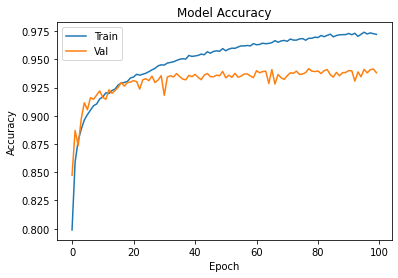

In [ ]:
# Plot graph 
# Source: https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
# Also has details on plotting loss instead, though we're asked to plot accuracy
plt.plot(train_model.history['accuracy'])
plt.plot(train_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
convnet_acc = 0.9297999739646912

## 6) Hyperparameters Tuning

*Grid Search for Best Model*

**Objective:**

Our approach is to use a Keras MLP for faster training (via GPU acceleration) and, in our grid search, vary exclusively the hyperparameters our model consists of. This way, we can then transfer this information on the hyperparameters to our own MLP implementation as a way of getting a performant model. 


**Note:**

From scikit-learn.org: "The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.".
This means that we can use x_train and y_train, without splitting it ourselves in training vs. validation format.


**References:**
Please note that the code in this section is heavily inspired by those 3 sources:
*   https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
*   https://colab.research.google.com/github/yueliyl/comp551-notebooks/blob/master/AutoDiffMLP.ipynb#scrollTo=g22608tCOA3M
*   https://www.geeksforgeeks.org/hyperparameter-tuning-using-gridsearchcv-and-kerasclassifier/



In [ ]:
# Building our model using Keras MLP

numberOfHiddenUnits = 128   # In our experiments, we use 128 hidden units

# KerasClassifier requires us to create a function that returns a model
def build_model():
  model = Sequential()
  model.add(Dense(numberOfHiddenUnits, input_shape=(X_train.shape[1],), activation='relu')) # Hidden Layer 1
  model.add(Dense(numberOfHiddenUnits, activation='relu'))  # Hidden Layer 2
  model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

  #need to compile the model
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model

# Now, we need to wrap our model in Scikit-Learn. 
model = KerasClassifier(model = build_model, verbose=0)

# Set seed for Tensorflow
tf.random.set_seed(12)

batch_size = [200, 800, 1600]   # possible mini-batch sizes
epochs = [50,100,150, 200]      # possible epochs
param_grid = dict(batch_size = batch_size, epochs=epochs)
n_jobs = -1 #to use all processors available for parallelism
cv = 5 # 5-fold cross validation

grid = GridSearchCV(estimator = model, param_grid=param_grid, n_jobs=n_jobs, cv=cv)
grid_result=grid.fit(X_train, y_train)


# Results 
# Code from https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
print("Best accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best accuracy: 0.895250 using {'batch_size': 200, 'epochs': 200}
0.894867 with: {'batch_size': 200, 'epochs': 50}
0.892200 with: {'batch_size': 200, 'epochs': 100}
0.892167 with: {'batch_size': 200, 'epochs': 150}
0.895250 with: {'batch_size': 200, 'epochs': 200}
0.895033 with: {'batch_size': 800, 'epochs': 50}
0.891933 with: {'batch_size': 800, 'epochs': 100}
0.890500 with: {'batch_size': 800, 'epochs': 150}
0.889383 with: {'batch_size': 800, 'epochs': 200}
0.890783 with: {'batch_size': 1600, 'epochs': 50}
0.893067 with: {'batch_size': 1600, 'epochs': 100}
0.891250 with: {'batch_size': 1600, 'epochs': 150}
0.889117 with: {'batch_size': 1600, 'epochs': 200}


## 7) Final Model
We run this final model with the best results from hyperparameter tuning (200 epochs, mini batch size of 200) and the best activation function (leaky ReLU).

100%|██████████| 200/200 [2:52:37<00:00, 51.79s/it]


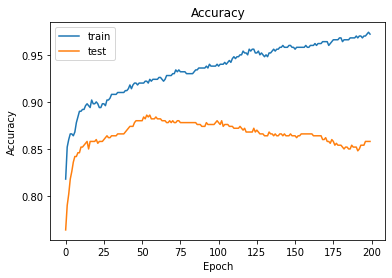

Accuracy:  0.8737


0.8737

In [ ]:
mini_batch_size = 200
epoch_number = 200
numHiddenLayers = 2
HIDDEN_SIZE = 128
lmbd=2

inputSize = X_train.shape[1]
outputSize = y_train.shape[1]
model = MLP("leaky_relu", numHiddenLayers , HIDDEN_SIZE, inputSize, outputSize, epoch_number, mini_batch_size, regularization=True, lmbd=lmbd)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
model.evaluate_acc(y_test, y_pred)